In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OneHotEncoder
import os
import matplotlib.pyplot as plt
import collections
from sklearn.model_selection import train_test_split, StratifiedKFold
import gc
from sklearn.metrics import mean_squared_error
from tqdm.notebook import tqdm
import lightgbm as lgb
import shap
import math
from pdpbox import pdp, get_dataset, info_plots
import matplotlib.image as mpimg
from sklearn.cluster import KMeans
from haversine import haversine
from math import radians, cos, sin, asin, sqrt
from bayes_opt import BayesianOptimization
import warnings

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

pd.options.mode.chained_assignment = None

path = '../input/california-housing-prices'

california_img=mpimg.imread('../input/california-housing-feature-engineering/california.png')


/kaggle/input/california-housing-prices/housing.csv
/kaggle/input/california-housing-feature-engineering/cal_populations_city.csv
/kaggle/input/california-housing-feature-engineering/cal_cities_lat_long.csv
/kaggle/input/california-housing-feature-engineering/california.png
/kaggle/input/california-housing-feature-engineering/cal_populations_county.csv


In [2]:
def sd(col, max_loss_limit=0.001, avg_loss_limit=0.001, na_loss_limit=0, n_uniq_loss_limit=0, fillna=0):
    """
    max_loss_limit - don't allow any float to lose precision more than this value. Any values are ok for GBT algorithms as long as you don't unique values.
                     See https://en.wikipedia.org/wiki/Half-precision_floating-point_format#Precision_limitations_on_decimal_values_in_[0,_1]
    avg_loss_limit - same but calculates avg throughout the series.
    na_loss_limit - not really useful.
    n_uniq_loss_limit - very important parameter. If you have a float field with very high cardinality you can set this value to something like n_records * 0.01 in order to allow some field relaxing.
    """
    is_float = str(col.dtypes)[:5] == 'float'
    na_count = col.isna().sum()
    n_uniq = col.nunique(dropna=False)
    try_types = ['float16', 'float32']

    if na_count <= na_loss_limit:
        try_types = ['int8', 'int16', 'float16', 'int32', 'float32']

    for type in try_types:
        col_tmp = col

        # float to int conversion => try to round to minimize casting error
        if is_float and (str(type)[:3] == 'int'):
            col_tmp = col_tmp.copy().fillna(fillna).round()

        col_tmp = col_tmp.astype(type)
        max_loss = (col_tmp - col).abs().max()
        avg_loss = (col_tmp - col).abs().mean()
        na_loss = np.abs(na_count - col_tmp.isna().sum())
        n_uniq_loss = np.abs(n_uniq - col_tmp.nunique(dropna=False))

        if max_loss <= max_loss_limit and avg_loss <= avg_loss_limit and na_loss <= na_loss_limit and n_uniq_loss <= n_uniq_loss_limit:
            return col_tmp

    # field can't be converted
    return col

def reduce_mem_usage_sd(df, deep=True, verbose=False, obj_to_cat=False):
    numerics = ['int16', 'uint16', 'int32', 'uint32', 'int64', 'uint64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage(deep=deep).sum() / 1024 ** 2
    for col in tqdm(df.columns):
        col_type = df[col].dtypes

        # collect stats
        na_count = df[col].isna().sum()
        n_uniq = df[col].nunique(dropna=False)
        
        # numerics
        if col_type in numerics:
            df[col] = sd(df[col])

        # strings
        if (col_type == 'object') and obj_to_cat:
            df[col] = df[col].astype('category')
        
        if verbose:
            print(f'Column {col}: {col_type} -> {df[col].dtypes}, na_count={na_count}, n_uniq={n_uniq}')
        new_na_count = df[col].isna().sum()
        if (na_count != new_na_count):
            print(f'Warning: column {col}, {col_type} -> {df[col].dtypes} lost na values. Before: {na_count}, after: {new_na_count}')
        new_n_uniq = df[col].nunique(dropna=False)
        if (n_uniq != new_n_uniq):
            print(f'Warning: column {col}, {col_type} -> {df[col].dtypes} lost unique values. Before: {n_uniq}, after: {new_n_uniq}')

    end_mem = df.memory_usage(deep=deep).sum() / 1024 ** 2
    percent = 100 * (start_mem - end_mem) / start_mem
    print('Mem. usage decreased from {:5.2f} Mb to {:5.2f} Mb ({:.1f}% reduction)'.format(start_mem, end_mem, percent))
    return df

def rmse(y_true, y_pred):
    return math.sqrt(mean_squared_error(y_true, y_pred))

In [3]:
def loader(path = path):
    data = pd.read_csv(os.path.join(path, 'housing.csv'))
    
    numeric_col = ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income']
    categoric_col = [x for x in data.columns if x not in numeric_col and x!='median_house_value']

    data[categoric_col] = data[categoric_col].astype(str, copy = True)

    data['median_house_value'] = np.log1p(data['median_house_value'])
    
    strat = pd.qcut(data['median_house_value'], 50, duplicates = 'drop')

    le = LabelEncoder()
    strat = le.fit_transform(strat).astype(np.int16)

    assert collections.Counter(strat).most_common()[-1][1] > 5 

    del le
    gc.collect()

    sns.countplot(strat)

    print('Stratification:\n')
    plt.show()
    
    print('\n\n')
    
    return data, numeric_col, categoric_col, strat

def etl_pipeline(data):

    data['num_rooms'] = data['total_rooms'] / data['households']
    data['num_bedrooms'] = data['total_bedrooms'] / data['households']
    data['persons_per_house'] = data['population'] / data['households']
    data['income_per_person'] = data['median_income']/data['population']
    data['income_per_age'] = data['median_income']*data['housing_median_age']
    data['income_div_age'] = data['median_income']/data['housing_median_age']
    data['median_income_sq'] = data['median_income']**2

    data['log_rooms'] = np.log1p(data['total_rooms'])
    data['log_bed'] = np.log1p(data['total_bedrooms'])
    data['log_population'] = np.log1p(data['population'])
    data['log_median_income'] = np.log1p(data['median_income'])
    data['log_households'] = np.log1p(data['households'])

    data = reduce_mem_usage_sd(data)
    
    return data

def eda_pipeline(data, strat, categoric_col):
    
        #categoric pipeline
    for cat in categoric_col:
        ohe = LabelEncoder()
        
        data[cat] = ohe.fit_transform(data[cat].values)
    
    data = reduce_mem_usage_sd(data)
        
    train, test, train_strat, _ = train_test_split(data, strat, test_size = 0.2, random_state = 12345, shuffle = True, stratify = strat)

    train.reset_index(drop = True, inplace = True)
    test.reset_index(drop = True, inplace = True)
    
    y_train, y_test = train.pop('median_house_value').values, test.pop('median_house_value').values
        
    return(train, test, y_train, y_test, train_strat)

#Convert lat/long to coordinate
def lat_long_to_cart(long, lat):
    R = 6371

    lat_rad = [radians(x) for x in lat]
    long_rad = [radians(x) for x in long]

    x = [R * cos(lat_rad[x]) * cos(long_rad[x]) for x in range(len(lat_rad))]

    y = [R * cos(lat_rad[x]) * sin(long_rad[x]) for x in range(len(lat_rad))]

    z = [R * sin(lat_rad[x]) for x in range(len(lat_rad))]

    return x, y, z

def cart_to_lat_long(coord):
    x, y, z = coord[:, 0], coord[:, 1], coord[:, 2]
    R =  6371
    lat = np.degrees(np.arcsin(z/R))
    long = np.degrees(np.arctan2(y, x))
    return lat, long

def centroid_finder(coord, column, n_centroid = 20):
    x, y, z = coord

    weight = data[column]/sum(data[column])

    coord_ = pd.DataFrame({'x': x, 'y': y, 'z': z, 'weight': weight})

    kmeans = KMeans(n_clusters = n_centroid, random_state = 0, n_init = 30, max_iter = 1000).fit(coord_[['x', 'y', 'z']], coord_['weight'])

    lat, long = cart_to_lat_long(kmeans.cluster_centers_)
    
    cluster_id = kmeans.labels_
    
    center_cord = pd.DataFrame({'latitude': lat, 'longitude': long})
    return center_cord, cluster_id


def find_nearest(center_cord, data_coord, biggest_cluster):
    
    distance_list = []
    nearest_cluster = []
    
    for row in tqdm(data_coord.iterrows()):
        
        distance = [haversine(row[1].loc[['latitude', 'longitude']].values, center_cord.loc[int(x)].values) for x in biggest_cluster]
        
        nearest_big_cluster = str(biggest_cluster[np.argmin(distance)])
        distance = np.min(distance)
        
        distance_list += [distance]
        nearest_cluster += [nearest_big_cluster]
        
    return nearest_cluster, distance_list

def geospatial_feature_pipeline(data, coord):
    
    for col in tqdm(['housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income']):
        print(f'Beginning: {col} etl')
        
        center_cord, cluster_id = centroid_finder(coord, col, n_centroid = 20)

        data[f'cluster_{col}'] = cluster_id.astype(str)  #centroid association

        distance = [haversine(data.loc[x, ['latitude', 'longitude']].values, center_cord.loc[int(cluster_id[x])].values) for x in range(len(cluster_id))]

        data[f'distance_centroid_{col}'] = distance #distance from centroid

        #Mean/sum/std by cluster
        data[f'sum_{col}_by_cluster'] = data[[f'cluster_{col}', col]].groupby(f'cluster_{col}').transform(lambda x: x.sum())
        data[f'mean_{col}_by_cluster'] = data[[f'cluster_{col}', col]].groupby(f'cluster_{col}').transform(lambda x: x.mean())
        data[f'std_{col}_by_cluster'] = data[[f'cluster_{col}', col]].groupby(f'cluster_{col}').transform(lambda x: x.std())

        #Find top 5 cluster by sum/mean
        if col in ['population', 'households', 'median_income', 'housing_median_age']:
            top_sum = data[[f'cluster_{col}', col]].groupby(f'cluster_{col}').apply(lambda x: x[col].sum()).sort_values(ascending = False).iloc[:5].reset_index()[f'cluster_{col}'].tolist()

            #Find nearest of big cluster
            nearest_cluster, distance_list = find_nearest(center_cord, data[['latitude', 'longitude']], top_sum)
            
            data[f'nearest_big_cluster_{col}'] = nearest_cluster
            data[f'distance_nearest_big_cluster_{col}'] = distance_list
        
    data = reduce_mem_usage_sd(data)
    
    categoric_col = data.dtypes[data.dtypes == 'object'].index.tolist()
    numeric_col = [x for x in data.columns if x not in categoric_col and x != 'median_house_value']
    
    gc.collect()
    
    return data, categoric_col, numeric_col

def cv_scorer(params, df_train, train_strat, categoric_col, early_stop = 500, n_fold = 5):

    folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=0)

    score = 0

    np.random.seed(10)

    gc.collect()
    for fold_ , (trn_idx, val_idx) in enumerate(folds.split(df_train, train_strat)):

            gc.collect()

            train_x, train_y = df_train.loc[trn_idx,:], y_train[trn_idx]
            valid_x, valid_y = df_train.loc[val_idx,:], y_train[val_idx]

            model = lgb.train(
                params,
                lgb.Dataset(train_x, label = train_y, categorical_feature = categoric_col),
                100000, valid_sets = lgb.Dataset(valid_x, label = valid_y, categorical_feature = categoric_col),
                categorical_feature = categoric_col,
                valid_names ='validation',
                verbose_eval = 0, early_stopping_rounds = early_stop,

            )

            temp_y = model.predict(valid_x)

            temp_score = rmse(valid_y, temp_y)
            score += temp_score/n_fold
    return score

Stratification:



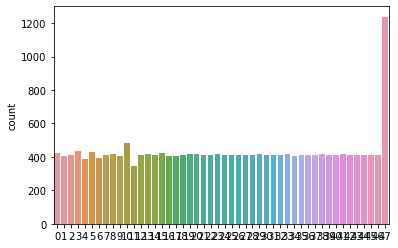

In [4]:
data, numeric_col, categoric_col, strat = loader()

In [5]:
data = etl_pipeline(data)


Mem. usage decreased from  4.59 Mb to  3.07 Mb (33.0% reduction)


Let's Visualize house value and population on the map

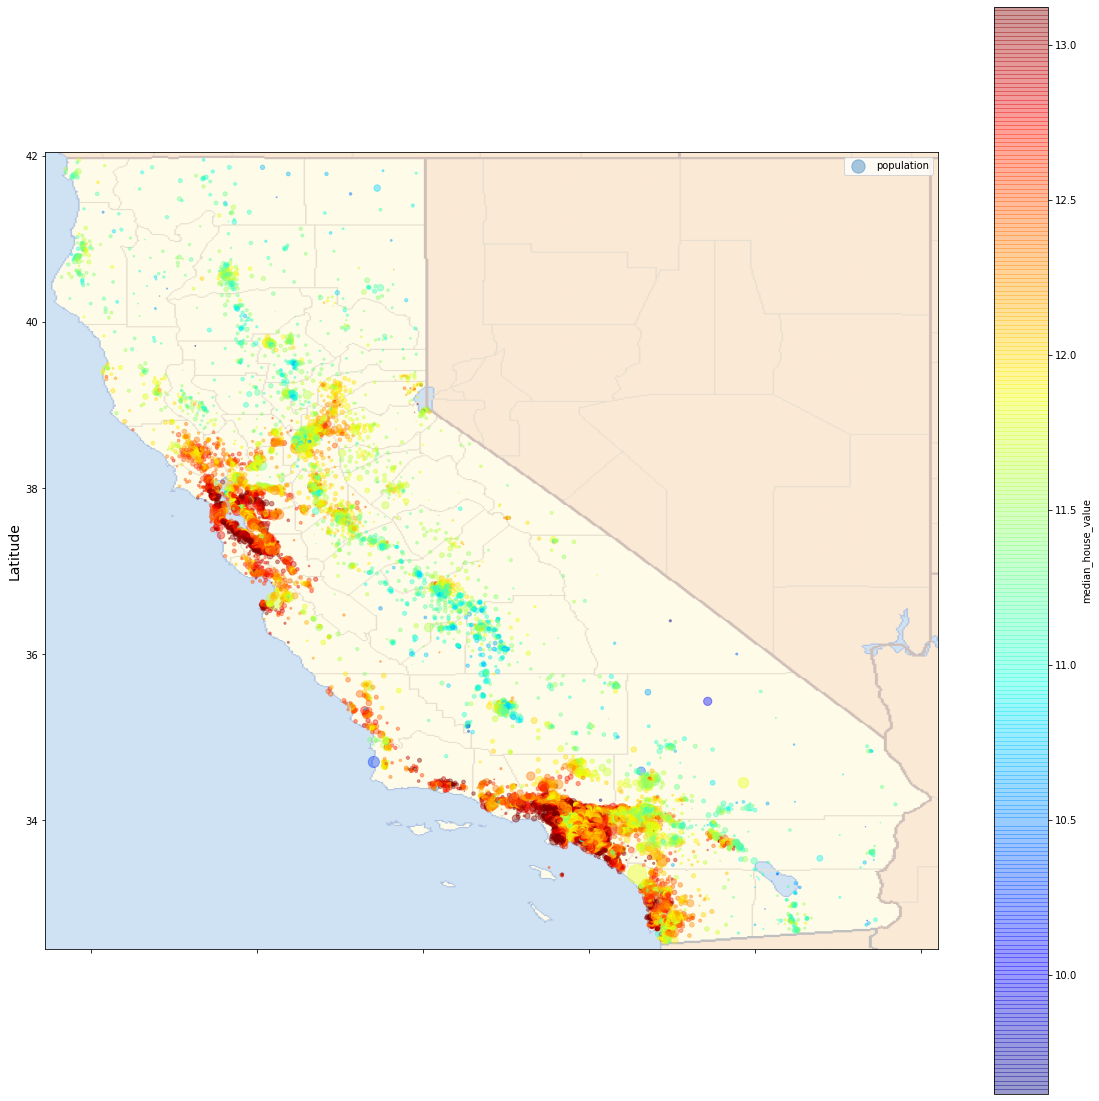

In [6]:
data.plot(kind='scatter', x='longitude', y='latitude', alpha=0.4,
          s=data['population']/100, label='population', figsize=(20, 20),
          c='median_house_value', cmap=plt.get_cmap('jet'), colorbar=True)


plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5)
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)
plt.legend() 
plt.show()


Now let's visualize the map only for population (log one for better representation)

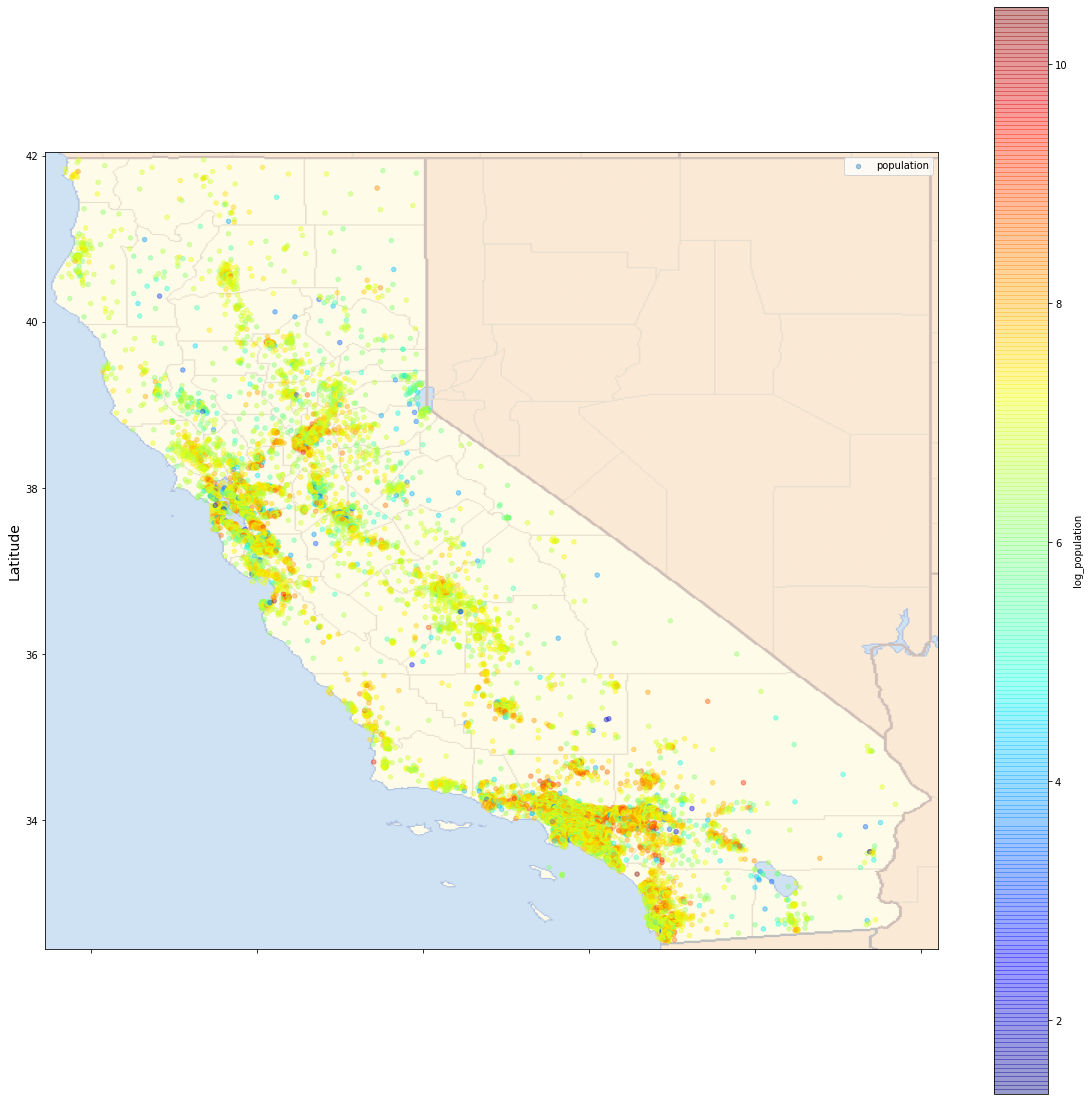

In [7]:
data.plot(kind='scatter', x='longitude', y='latitude', alpha=0.4,
          label='population', figsize=(20, 20),
          c='log_population', cmap=plt.get_cmap('jet'), colorbar=True
         )


plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5)
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)
plt.legend() 
plt.show()


Let's try to find city location by clustering method.

Let's find cartesian coordinate by latitude/longitude

In [8]:
coord = lat_long_to_cart(data.longitude, data.latitude)

Apply kmeans to cartesian coordinate, find centroid and their latitude/longitude

In [9]:
center_cord, cluster_id = centroid_finder(coord, 'log_population', n_centroid = 20)

It seems Kmeans is able to find main city in california.

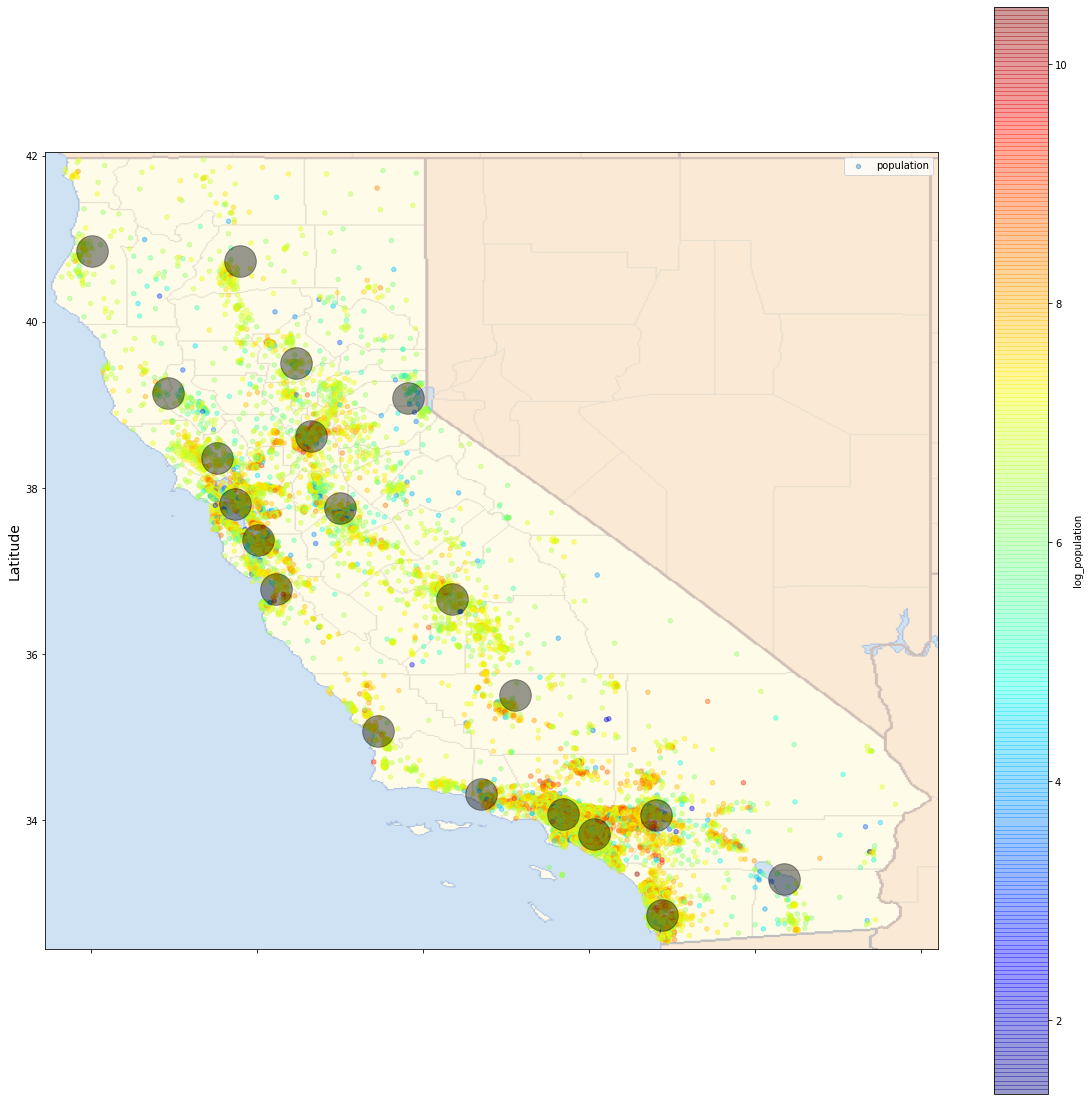

In [10]:
data.plot(kind='scatter', x='longitude', y='latitude', alpha=0.4,
          label='population', figsize=(20, 20), 
          c='log_population', cmap=plt.get_cmap('jet'), colorbar=True
         )

plt.scatter(
    x = center_cord.longitude, y = center_cord.latitude, alpha=0.4, s = 1000, c='black'
)

plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5)
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)
plt.legend() 
plt.show()


Now we'll apply this pipeline using different feature as weight for kmeans algorithm, in this way we'll find centroid relative to more information than only population.

In [11]:
data, categoric_col, numeric_col = geospatial_feature_pipeline(data, coord)

Beginning: housing_median_age etl



Beginning: total_rooms etl
Beginning: total_bedrooms etl
Beginning: population etl



Beginning: households etl



Beginning: median_income etl



Mem. usage decreased from 19.96 Mb to 18.50 Mb (7.3% reduction)


# Test split

In [12]:
df_train, df_test, y_train, y_test, train_strat = eda_pipeline(data, strat, categoric_col)


Mem. usage decreased from  6.48 Mb to  4.96 Mb (23.4% reduction)


In [13]:
seed = 1
params = {
                    'objective': 'regression',
                    'boosting_type':'gbdt',
                    'metric':'rmse',
                    'learning_rate':0.05,
                    'colsample_bytree': 0.8,
                    'lambda_l1': 2,
                    'max_depth': -1,
                    'num_leaves': 2**8,
                    'subsample': 0.75,
                    'tree_learner':'serial',
                    'max_bin':255,
                    'seed': seed,
                    'n_jobs':-1,
                    'importance_type':'gain',
}
gc.collect()

23

# Train the model in CV

In [14]:
n_fold = 5
folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=0)

pred = np.zeros(df_train.shape[0])
pred_test = np.zeros(df_test.shape[0])

shap_matrix = np.zeros(df_train.shape)

score = 0

model5 =[]

np.random.seed(10)

gc.collect()
for fold_ , (trn_idx, val_idx) in tqdm(enumerate(folds.split(df_train, train_strat))):
        
        gc.collect()
        
        train_x, train_y = df_train.loc[trn_idx,:], y_train[trn_idx]
        valid_x, valid_y = df_train.loc[val_idx,:], y_train[val_idx]
        
        model = lgb.train(
            params,
            lgb.Dataset(train_x, label = train_y, categorical_feature = categoric_col),
            100000, valid_sets = lgb.Dataset(valid_x, label = valid_y, categorical_feature = categoric_col),
            categorical_feature = categoric_col,
            valid_names ='validation',
            verbose_eval = 0, early_stopping_rounds = 500,

        )
    
        temp_y = model.predict(valid_x)
        iter_lgbm = model.best_iteration
        
        pred[val_idx] = temp_y
        pred_test += model.predict(df_test)/n_fold

        temp_score = rmse(valid_y, temp_y)
        score += temp_score/n_fold
        print('Fold: {}; rmsle: {:.3f}; Iter: {}\n\n'.format(fold_, temp_score, iter_lgbm))
        model5.append(model)
        
        explainer = shap.TreeExplainer(model)

        shap_matrix[val_idx, :] = explainer.shap_values(valid_x)[1]
        
print('CV - RMSLE : {}\n'.format(score))

test_score = math.sqrt(mean_squared_error(y_test, pred_test))
print('Test - RMSLE : {}\n'.format(test_score))
initial_error = test_score

Fold: 0; rmsle: 0.207; Iter: 672


Fold: 1; rmsle: 0.223; Iter: 689


Fold: 2; rmsle: 0.201; Iter: 452


Fold: 3; rmsle: 0.207; Iter: 417


Fold: 4; rmsle: 0.202; Iter: 417



CV - RMSLE : 0.20802474774596144

Test - RMSLE : 0.21159899206798896



# Explain the model with importance + shap + marginal

Text(0.5, 1.0, '50 TOP feature importance over 5 average')

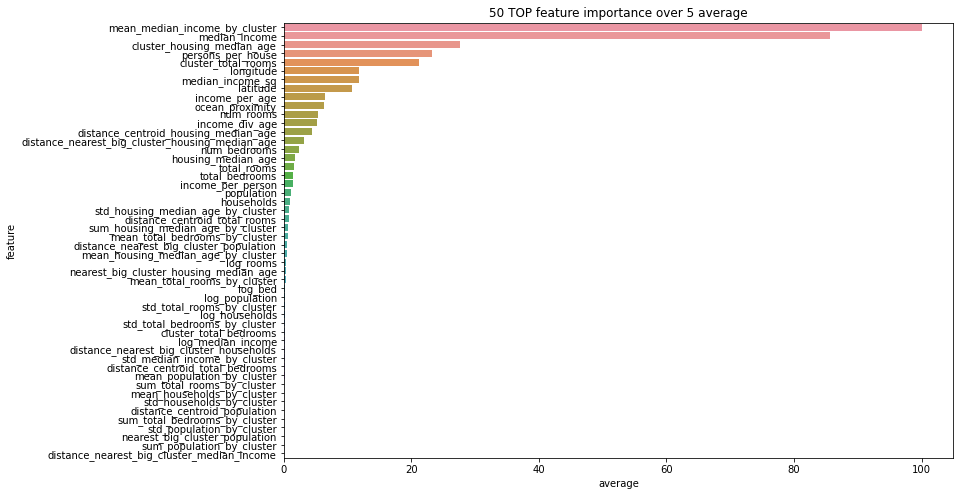

In [15]:
feature_importances = pd.DataFrame()
feature_importances['feature'] = df_train.columns


for fold_, mod in tqdm(enumerate(model5)):
    feature_importances['fold_{}'.format(fold_ + 1)] = mod.feature_importance(importance_type='gain')

    
scaler = MinMaxScaler(feature_range=(0, 100))


feature_importances['average'] = scaler.fit_transform(X=pd.DataFrame(feature_importances[['fold_{}'.format(fold + 1) for fold in range(folds.n_splits)]].mean(axis=1)))

fig = plt.figure(figsize=(12,8))
sns.barplot(data=feature_importances.sort_values(by='average', ascending=False).head(50), x='average', y='feature');
plt.title('50 TOP feature importance over {} average'.format(fold_+1))


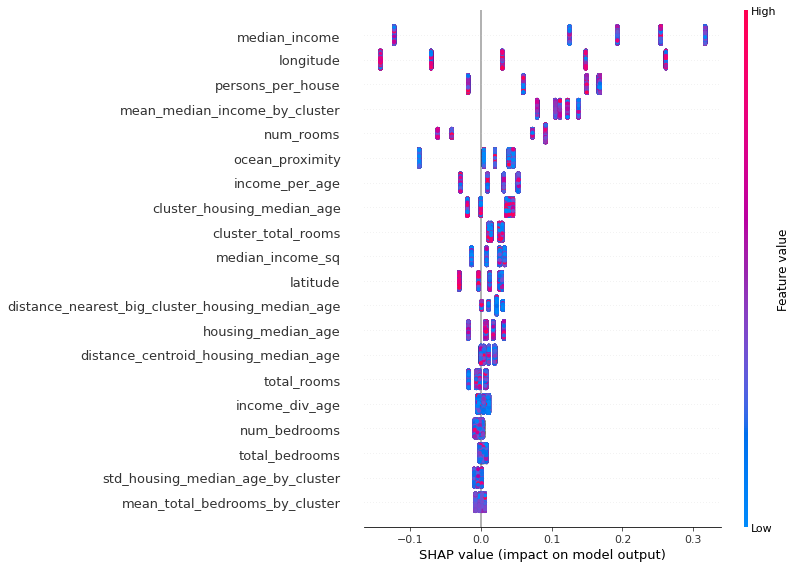

In [16]:
shap.summary_plot(shap_matrix, df_train)

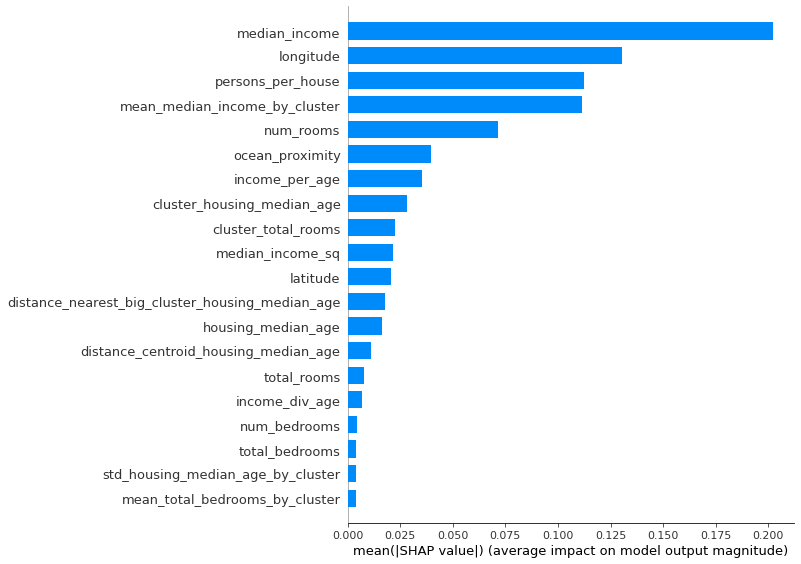

In [17]:
shap.summary_plot(shap_matrix, df_train, plot_type="bar")

# Partial plot

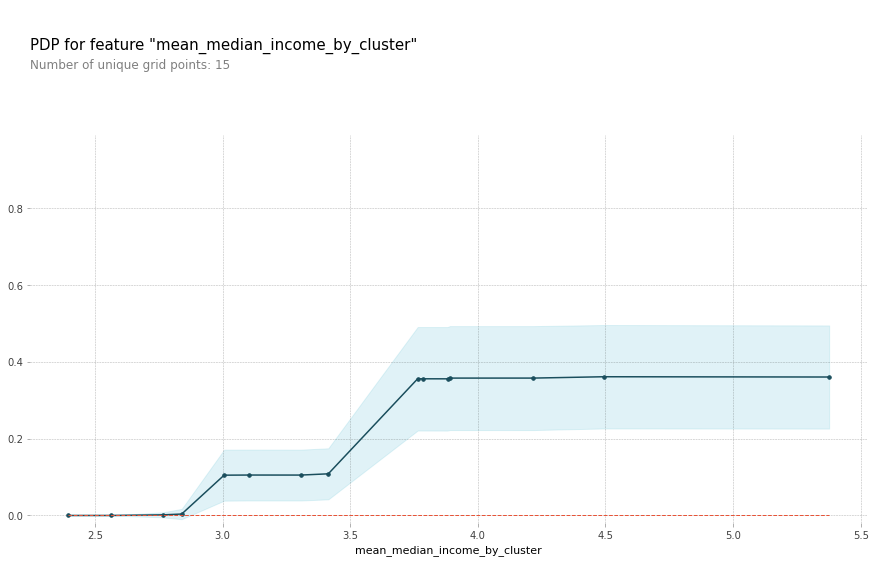

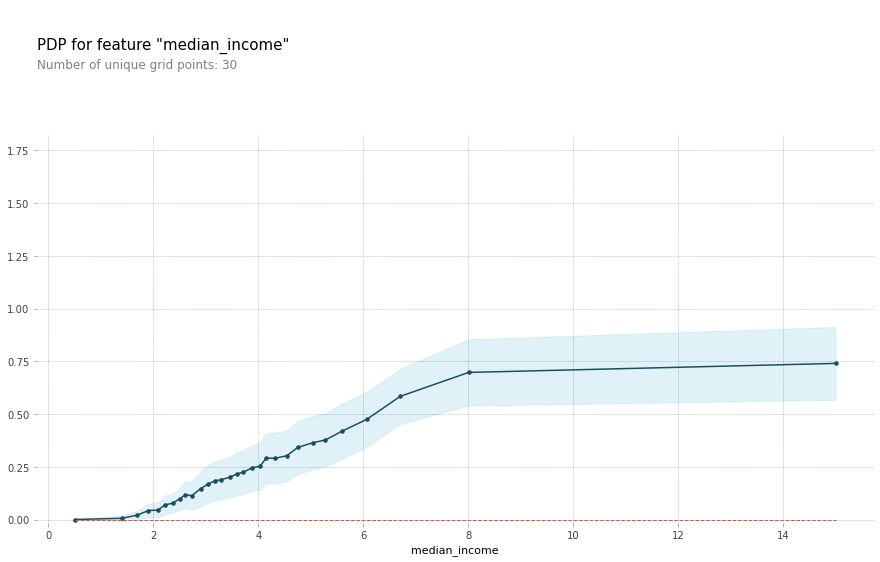

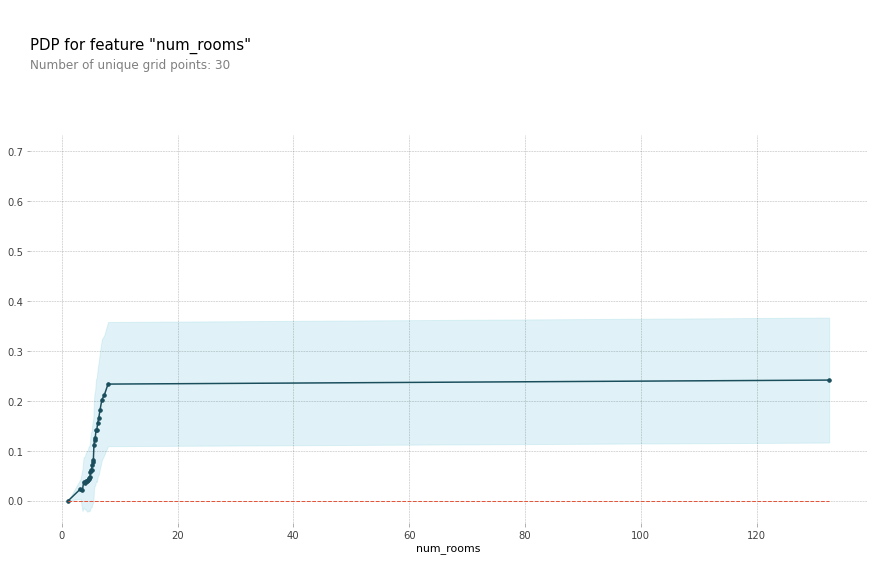

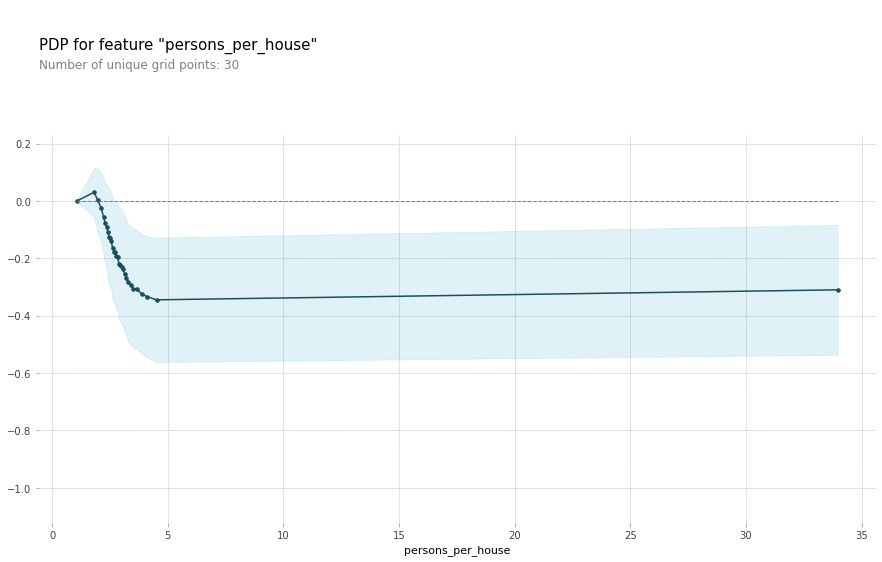

In [18]:
#Single partial plot
for features_to_plot in ["mean_median_income_by_cluster", "median_income", "num_rooms", "persons_per_house"]:
    pdp_dist  =  pdp.pdp_isolate(model = model, dataset = valid_x, model_features = df_train.columns, feature = features_to_plot, num_grid_points = 30)

    pdp.pdp_plot(pdp_dist, features_to_plot)
    plt.show()


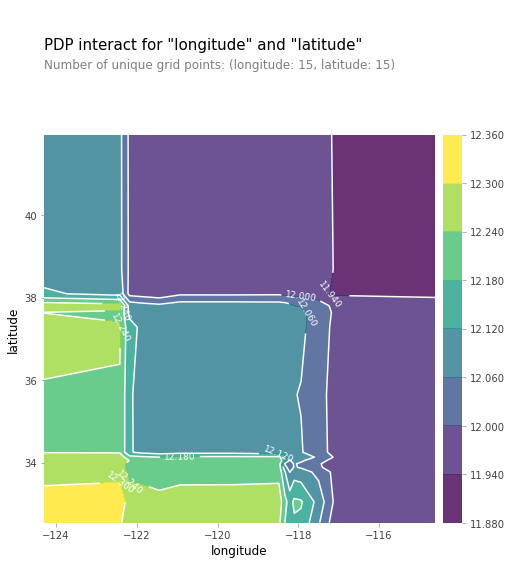

In [19]:
#Interaction plot
features_to_plot = ["longitude", "latitude"]
inter1  =  pdp.pdp_interact(model = model, dataset = valid_x, model_features = df_train.columns, features=features_to_plot, num_grid_points = [15, 15])

pdp.pdp_interact_plot(pdp_interact_out=inter1, feature_names=features_to_plot, plot_type='contour')
plt.show()


# Test Prediction

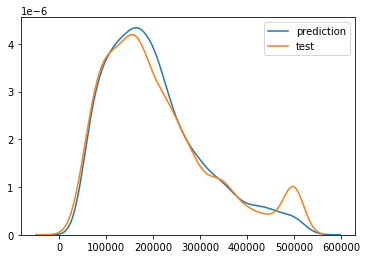

In [20]:
sns.distplot(np.expm1(pred_test), label= 'prediction', hist = False)
sns.distplot(np.expm1(y_test), label = 'test', hist = False)
plt.legend()

# Feature selection with shap and retrain

In [21]:
Importance = pd.DataFrame({'feature': valid_x.columns, 'Value': np.abs(shap_matrix).mean(axis = 0)}).sort_values('Value', ascending = False).reset_index(drop = True)
selected = Importance[Importance.Value > np.quantile(Importance.Value, .6)].feature.tolist()

df_train_filtered = df_train[selected]
df_test_filtered = df_test[selected]

categoric_col_filtered = [x for x in categoric_col if x in selected]

Estimate cv error after feature selection

In [22]:
%%time
test_score = cv_scorer(params, df_train_filtered, train_strat, categoric_col_filtered)

print(f'Initial score: {initial_error}; After feature Selection: {test_score}; Delta: {initial_error - test_score}')

Initial score: 0.21159899206798896; After feature Selection: 0.20705916924342324; Delta: 0.00453982282456572
CPU times: user 2min 22s, sys: 1.41 s, total: 2min 24s
Wall time: 38.4 s


# Parameter Tuning Phase

In [23]:
import itertools

colsample = [.8, 1]
subsample = [.75, 1]
max_depth = [-1, 6, 8]
num_leaves = [2**x for x in np.arange(6, 12, 2)]
lambda_l1 = [0, .5, 1]
lambda_l2 = [0, .5, 1]

score_list = []

par_grid = list(itertools.product(colsample, subsample, max_depth, num_leaves, lambda_l1, lambda_l2))

for par in tqdm(par_grid):
    
    if par_grid[1] != 1:
        subsample_freq = 5
        
    params = {
                    'objective': 'regression',
                    'boosting_type':'gbdt',
                    'metric':'rmse',
                    'learning_rate':0.1,
                    'colsample_bytree': par[0],
                    'lambda_l1': par[4],
                    'lambda_l2': par[5],
                    'max_depth': par[2],
                    'num_leaves': par[3],
                    'subsample': par[1],
                    'subsample_freq': subsample_freq,
                    'tree_learner':'serial',
                    'max_bin':255,
                    'seed': seed,
                    'n_jobs':-1,
                    'importance_type':'gain',
    }

    score_list += [cv_scorer(params, df_train_filtered, train_strat, categoric_col_filtered, early_stop = 150, n_fold = 2)]

In [24]:
final_parameter = par_grid[np.argmin(score_list)]
params = {
                    'objective': 'regression',
                    'boosting_type':'gbdt',
                    'metric':'rmse',
                    'learning_rate':0.01,
                    'colsample_bytree': par[0],
                    'lambda_l1': par[4],
                    'lambda_l2': par[5],
                    'max_depth': par[2],
                    'num_leaves': par[3],
                    'subsample': par[1],
                    'subsample_freq': 5,
                    'tree_learner':'serial',
                    'max_bin': 510,
                    'seed': seed,
                    'n_jobs':-1,
                    'importance_type':'gain',
}
    
params

{'objective': 'regression',
 'boosting_type': 'gbdt',
 'metric': 'rmse',
 'learning_rate': 0.01,
 'colsample_bytree': 1,
 'lambda_l1': 1,
 'lambda_l2': 1,
 'max_depth': 8,
 'num_leaves': 1024,
 'subsample': 1,
 'subsample_freq': 5,
 'tree_learner': 'serial',
 'max_bin': 510,
 'seed': 1,
 'n_jobs': -1,
 'importance_type': 'gain'}

After selected feature and parameter let's retrain final model

In [25]:
n_fold = 5
folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=0)

pred = np.zeros(df_train.shape[0])
pred_test = np.zeros(df_test.shape[0])

score = 0

model5 =[]

np.random.seed(10)

gc.collect()
for fold_ , (trn_idx, val_idx) in tqdm(enumerate(folds.split(df_train_filtered, train_strat))):
        
        gc.collect()
        
        train_x, train_y = df_train_filtered.loc[trn_idx,:], y_train[trn_idx]
        valid_x, valid_y = df_train_filtered.loc[val_idx,:], y_train[val_idx]
        
        model = lgb.train(
            params,
            lgb.Dataset(train_x, label = train_y, categorical_feature = categoric_col_filtered),
            100000, valid_sets = lgb.Dataset(valid_x, label = valid_y, categorical_feature = categoric_col_filtered),
            categorical_feature = categoric_col_filtered,
            valid_names ='validation',
            verbose_eval = 0, early_stopping_rounds = 500,

        )
    
        temp_y = model.predict(valid_x)
        iter_lgbm = model.best_iteration
        
        pred[val_idx] = temp_y
        pred_test += model.predict(df_test_filtered)/n_fold

        temp_score = rmse(valid_y, temp_y)
        score += temp_score/n_fold
        print('Fold: {}; rmsle: {:.3f}; Iter: {}\n\n'.format(fold_, temp_score, iter_lgbm))
        model5.append(model)
                
print('CV - RMSLE : {}\n'.format(score))

test_score = math.sqrt(mean_squared_error(y_test, pred_test))
print('Test - RMSLE : {}\n'.format(test_score))


Fold: 0; rmsle: 0.206; Iter: 4990


Fold: 1; rmsle: 0.221; Iter: 4314


Fold: 2; rmsle: 0.199; Iter: 4789


Fold: 3; rmsle: 0.206; Iter: 4885


Fold: 4; rmsle: 0.202; Iter: 4747



CV - RMSLE : 0.20676564833519695

Test - RMSLE : 0.20940808313961246



# Distinctive plot

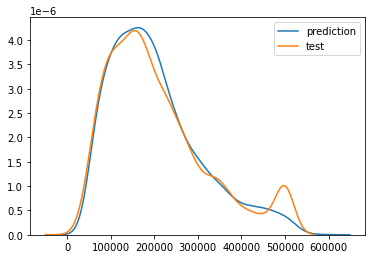

In [26]:
sns.distplot(np.expm1(pred_test), label= 'prediction', hist = False)
sns.distplot(np.expm1(y_test), label = 'test', hist = False)
plt.legend()